# Parameter-Efficient Fine-Tuning (PEFT) [Tutorial]

**NOTE:** This assignment is prepared by Abhinav Joshi (<ajoshi@cse.iitk.ac.in>) and Ashutosh Modi (<ashutoshm@cse.iitk.ac.in>), it is only for personal use. Please do not share it further or post it on internet. In case of any mistake please report to Abhinav Joshi (<ajoshi@cse.iitk.ac.in>). Thanks!

Parameter-Efficient Fine-Tuning (PEFT) is a set of advanced techniques designed to address these challenges by reducing the number of trainable parameters required for fine-tuning LLMs. PEFT methods enable efficient adaptation of pre-trained models to specific tasks while significantly lowering memory requirements and training time. Despite the reduction in trainable parameters, PEFT methods can maintain performance levels close to those achieved by full fine-tuning.

PEFT techniques are particularly valuable in scenarios where resources are limited or when multiple models need to be fine-tuned for different tasks. These methods allow practitioners to leverage the power of large pre-trained models without the associated computational overhead.

### Popular PEFT Approaches

There are several popular approaches to PEFT, each with its unique advantages and use cases (in this tutorial, we will try to go over some of the broader categories of these PEFT approaches):

1. **Soft-Prompt Tuning**:
   - **Concept**: Instead of updating the entire model, soft-prompt tuning involves learning a small set of additional tokens (soft prompts) that are prepended to the input sequence.
   - **Mechanism**: The model parameters remain fixed, and only the soft prompts are optimized during training.
   - **Advantages**: This method significantly reduces the number of trainable parameters and can be quickly adapted to different tasks.
   - **Use Cases**: Suitable for scenarios where task-specific information can be encoded in a few tokens.

2. **Adapter-Based Fine-Tuning**:
   - **Concept**: Adapter modules are small neural networks inserted into each layer of the pre-trained model. During fine-tuning, only these adapters are updated, while the original model parameters are kept fixed.
   - **Mechanism**: Adapters typically consist of a down-projection, non-linearity, and an up-projection.
   - **Advantages**: Allows fine-tuning with minimal computational overhead and maintains the pre-trained knowledge intact.
   - **Use Cases**: Ideal for multi-task learning and situations where maintaining the original model's generalization capability is crucial.

3. **LoRA (Low-Rank Adaptation)**:
   - **Concept**: LoRA approximates weight updates using low-rank matrices. It decomposes the weight update matrix into the product of two smaller matrices, significantly reducing the number of parameters to be updated.
   - **Mechanism**: Only the low-rank matrices are trained, while the rest of the model remains unchanged.
   - **Advantages**: Efficient in terms of both memory and computation, and it can be applied to any layer of the model.
   - **Use Cases**: Useful for tasks where fine-tuning large models on limited hardware is required.

We chose the three categories due to their difference in implementation style, boardly the other PEFT approaches follow one of the above structure for updating the model parameters.

### Why Use PEFT?

- **Resource Efficiency**: PEFT methods drastically reduce the memory footprint and computational cost associated with fine-tuning large models.
- **Scalability**: These techniques make it feasible to fine-tune multiple models for different tasks without requiring extensive hardware resources.
- **Flexibility**: PEFT approaches can be adapted to a wide range of NLP tasks, providing a versatile toolkit for model fine-tuning.

## Tutorial Overview

In this tutorial, we will explore how to implement different PEFT approaches and learn how to to update these large pretrained models with low-resources.



By the end of this tutorial, you will have a solid understanding of how to apply some of the popular parameter efficient fine tuning approaches to large models and leverage PEFT techniques to optimize model performance efficiently.

Let's get started!

In [ ]:
%%capture
# install the required libraries
!pip install datasets transformers peft

In [ ]:
# import the required libraries
import torch
import datasets
from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType, PrefixTuningConfig, PromptEncoderConfig
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display, HTML
import time
from tqdm.notebook import tqdm

#### For our experiments, we would need:
* Pretrained model (we can use t5-small for running the experiments faster, or a smaller autoregressive model like gpt-neo-125M)
* a sample dataset on which we can tune our model (datsets like IMDB comes in * handy when learning something new)




**Models:**
* For more details about the T5 Model architecture, please refer: https://huggingface.co/docs/transformers/en/model_doc/t5

* For more details about the GPT-Neo Model architecture, please refer: https://huggingface.co/docs/transformers/en/model_doc/gpt_neo

**IMDB Dataset:**
* To have a look at the IMDB dataset: https://huggingface.co/datasets/stanfordnlp/imdb

* Details about the dataset: https://aclanthology.org/P11-1015.pdf


In [ ]:
# Let's also fix some GLOBAL parameters so that we can compare the models trained with different configurations

# fix the random seed for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# fix the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fix the model name
T5_MODEL_NAME = "t5-small"
CAUSAL_MODEL_NAME = "EleutherAI/gpt-neo-125M"

# fix the number of epochs
EPOCHS = 3

# fix the batch size
BATCH_SIZE = 8

# fix the learning rate
LEARNING_RATE = 1e-4

DATASET_NAME = "imdb"

MAX_LENGTH = 512

# loading dataset
dataset = load_dataset("imdb", split=['train[45%:55%]', 'test[45%:55%]', 'unsupervised[45%:55%]'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# classes = ["negative", "positive"]
classes = ["neg", "pos"]
DATASET = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)

In [ ]:
# have a look at a dataset sample for sanity check
dataset["train"][0]

## 0. Fine-Tuning

Before diving into PEFT techniques, let's first understand the standard fine-tuning process for large language models. Fine-tuning involves updating the weights of a pre-trained model on a specific task or dataset. This process allows the model to adapt to new data and improve its performance on the target task.

This will also help us set a baseline for comparison with the PEFT methods we will explore later in the tutorial.

In [ ]:
# # setup the parameters for the training

# text_column = "text"
# label_column = "text_label"
# max_length = 128
# lr = 1e-2
# num_epochs = 25
# batch_size = 8 # try reducing the batch size or the max_length if you run out of memory

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# setup the parameters for the training using the global variables

text_column = "text"
label_column = "text_label"
max_length = MAX_LENGTH
lr = LEARNING_RATE
num_epochs = EPOCHS
batch_size = BATCH_SIZE # try reducing the batch size or the max_length if you run out of memory

device = DEVICE

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup

model_name_or_path = "t5-small"
tokenizer_name_or_path = "t5-small"

# creating model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)

# lets see the model architecture
model

In [ ]:
# # loading dataset
# dataset = load_dataset("imdb", split=['train[45%:55%]', 'test[45%:55%]', 'unsupervised[45%:55%]'])
# dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
# dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# # classes = ["negative", "positive"]
# classes = ["neg", "pos"]
# dataset = dataset.map(
#     lambda x: {"text_label": [classes[label] for label in x["label"]]},
#     batched=True,
#     num_proc=1,
# )

# dataset["train"][0]

In [ ]:
# use global dataset instead
dataset = DATASET

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=2, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)


In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())

    train_accuracy = sum([1 if (true == pred).all() else 0 for true, pred in zip(true_labels, predicted_labels)]) / len(true_labels)

    model.eval()
    eval_loss = 0
    eval_preds = []
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())



    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # compute accuracy
    true_labels = [label for labels in true_labels for label in labels]
    predicted_labels = [label for labels in predicted_labels for label in labels]
    correct = sum([1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)])
    validation_accuracy = correct / len(true_labels)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=} {train_accuracy=} {validation_accuracy=}")
    logs_for_plots[epoch] = {"train_ppl": train_ppl.cpu().numpy(), "train_loss": train_epoch_loss.cpu().numpy(), "eval_ppl": eval_ppl.cpu().numpy(), "eval_loss": eval_epoch_loss.cpu().numpy(),
                             "train_accuracy": train_accuracy,
                             "validation_accuracy": validation_accuracy}





In [ ]:
# plot the logs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots], label="train", color="red")
ax[0].plot([logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots], label="val", color="blue")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot([logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots], label="train", color="red")
ax[1].plot([logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots], label="val", color="blue")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
plt.show()

<!-- #@title Your Title Here -->


## 1. Soft-Prompt Tuning

### What exactly happens in soft-prompt tuning.
Soft-prompt tuning involves prepending a set of trainable "soft prompts" to the input sequence. These prompts are learned during fine-tuning and guide the model's behavior for the specific task.

#### A simple mathematical intuition:

Let $ x $ be the input sequence and $ p $ be the soft prompt. The new input becomes:
$$
x' = [p; x]
$$
The objective is to learn $ p $ while keeping the rest of the model fixed. The forward pass can be expressed as:
$$
y = f(x') = f([p; x])
$$
where $ f $ is the pretrained model function.


### Implementation
Let's start implementing the soft-prompt tuning, we will proceed with the following steps:
1. **Setting Up the Environment**: Install necessary libraries and set up the GPU environment.
2. **Loading and Tokenizing the Dataset**: Prepare the data for training.
3. **Configuring Soft-Prompt Tuning**: Define the configuration for soft-prompt tuning.
4. **Training the Model**: Perform the training loop with soft-prompt tuning.
5. **Evaluation and Analysis**: Evaluate the fine-tuned model and analyze the results.


### **Prefix-Tuning: Optimizing Continuous Prompts for Generation**

Paper: https://arxiv.org/pdf/2101.00190



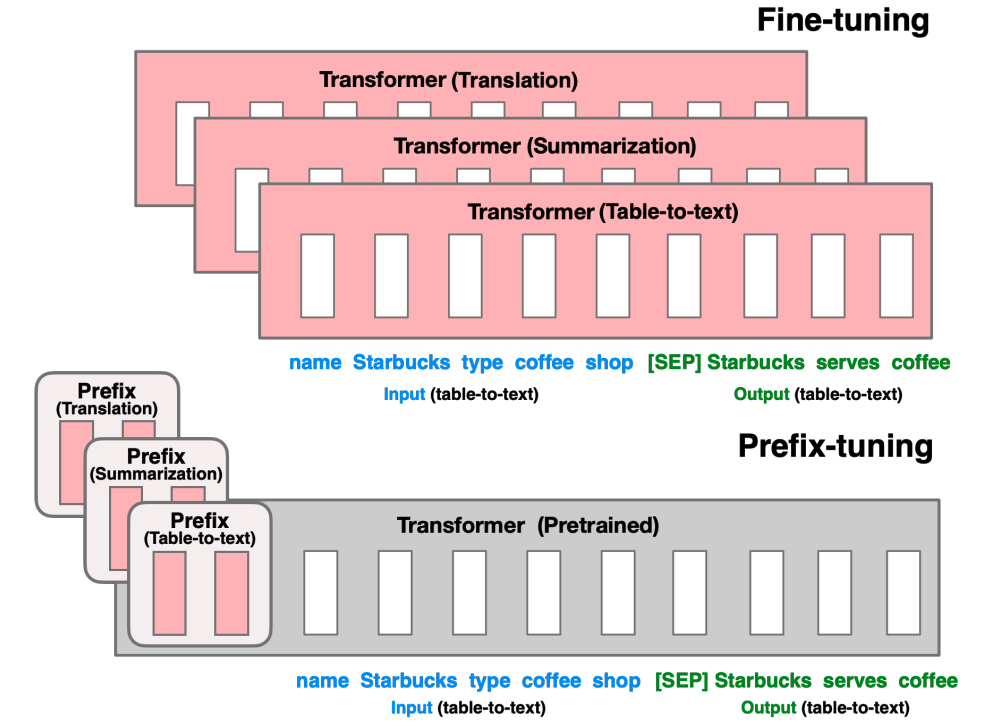


In [ ]:
# load the required libraries and set some environment variables
import os
import torch
import datasets

from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig, TaskType
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = DEVICE


In [ ]:
# text_column = "text"
# label_column = "text_label"
# max_length = 128
# lr = 1e-2
# num_epochs = 5
# batch_size = 8

In [ ]:
# use GLOBAL parameters instead
text_column = "text"
label_column = "text_label"
max_length = MAX_LENGTH
lr = LEARNING_RATE
num_epochs = EPOCHS
batch_size = BATCH_SIZE

In [ ]:

model_name_or_path = "t5-small"
tokenizer_name_or_path = "t5-small"

# creating model
peft_config = PrefixTuningConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model

In [ ]:
# # loading dataset
# dataset = load_dataset("imdb", split=['train[45%:55%]', 'test[45%:55%]', 'unsupervised[45%:55%]'])
# dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
# dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# # classes = ["negative", "positive"]
# classes = ["neg", "pos"]
# dataset = dataset.map(
#     lambda x: {"text_label": [classes[label] for label in x["label"]]},
#     batched=True,
#     num_proc=1,
# )

# dataset["train"][0]

In [ ]:
# use global dataset instead
dataset = DATASET

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=2, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)


Now since we have the dataloaders ready, let's strt training our PEFT model.

In [ ]:
# define the optimizer and learning rate scheduler



In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

Start training

In [ ]:
# write the training loop with required training logs

# 1. iterate over the training dataloaders
# 2. compute the loss and update the model parameter using backprop
# 3. compute the predicted token ids and log the losses for visualization

# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}

        # put your code here....



In [ ]:
# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())

    train_accuracy = sum([1 if (true == pred).all() else 0 for true, pred in zip(true_labels, predicted_labels)]) / len(true_labels)

    model.eval()
    eval_loss = 0
    eval_preds = []
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())



    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # compute accuracy
    true_labels = [label for labels in true_labels for label in labels]
    predicted_labels = [label for labels in predicted_labels for label in labels]
    correct = sum([1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)])
    validation_accuracy = correct / len(true_labels)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=} {train_accuracy=} {validation_accuracy=}")
    logs_for_plots[epoch] = {"train_ppl": train_ppl.cpu().numpy(), "train_loss": train_epoch_loss.cpu().numpy(), "eval_ppl": eval_ppl.cpu().numpy(), "eval_loss": eval_epoch_loss.cpu().numpy(),
                             "train_accuracy": train_accuracy,
                             "validation_accuracy": validation_accuracy}





In [ ]:
# plot the logs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots], label="train", color="red")
ax[0].plot([logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots], label="val", color="blue")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")


ax[1].plot([logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots], label="train", color="red")
ax[1].plot([logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots], label="val", color="blue")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create subplots
# fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss (Perplexity)", "Accuracy"),
#                     shared_yaxes=True)

# # Add traces for Loss plot
# fig.add_trace(
#     go.Scatter(x=list(logs_for_plots.keys()), y=[logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots],
#                name="Train Loss", line=dict(color="red", width=2)),
#     row=1, col=1
# )
# fig.add_trace(
#     go.Scatter(x=list(logs_for_plots.keys()), y=[logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots],
#                name="Validation Loss", line=dict(color="blue", width=2)),
#     row=1, col=1
# )

# # Add traces for Accuracy plot
# fig.add_trace(
#     go.Scatter(x=list(logs_for_plots.keys()), y=[logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots],
#                name="Train Accuracy", line=dict(color="red", width=2)),
#     row=1, col=2
# )
# fig.add_trace(
#     go.Scatter(x=list(logs_for_plots.keys()), y=[logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots],
#                name="Validation Accuracy", line=dict(color="blue", width=2)),
#     row=1, col=2
# )

# # Update layout
# fig.update_layout(
#     title_text="Training and Validation Metrics",
#     height=600,
#     width=1000,
#     showlegend=True,
#     legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
#     font=dict(family="Arial", size=12),
#     plot_bgcolor="white",
# )

# # Update axes
# fig.update_xaxes(title_text="Epochs", showgrid=True, gridwidth=1, gridcolor='lightgray')
# fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# # Show the plot
# fig.show()

### **P-Tuning: GPT Understands, Too**

Paper Title: GPT Understands, Too

Paper Link : https://arxiv.org/pdf/2103.10385

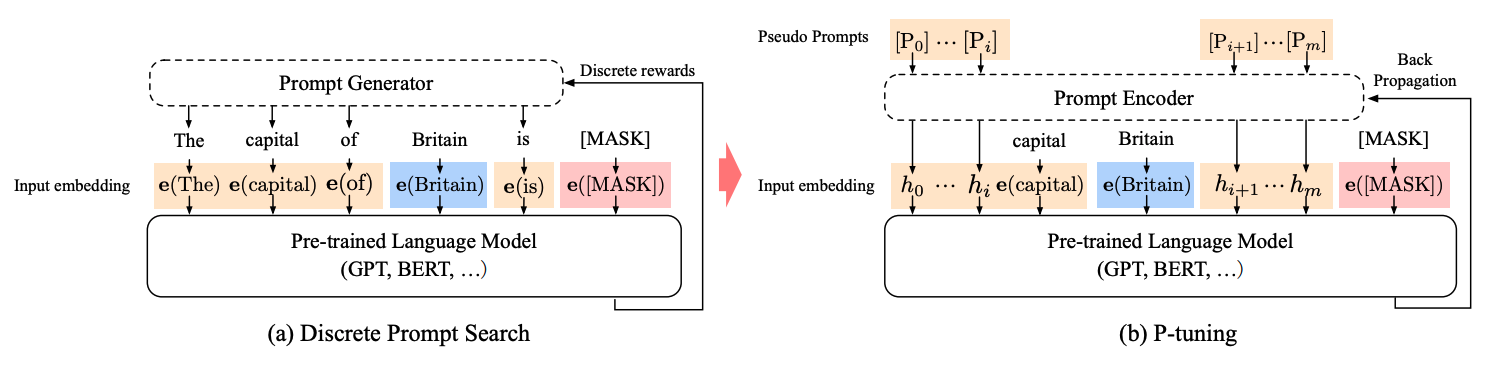

In [ ]:
# model_name_or_path = "t5-small"
# task = "mrpc"
# num_epochs = 20
# lr = 1e-3
# batch_size = 32

In [ ]:
model_name_or_path = "t5-small"
task = "mrpc"
num_epochs = EPOCHS
lr = LEARNING_RATE
batch_size = BATCH_SIZE
max_length = MAX_LENGTH

In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PromptEncoderConfig,
)
from datasets import load_dataset
import evaluate
import torch



peft_config = PromptEncoderConfig(task_type="SEQ_2_SEQ_LM", num_virtual_tokens=20, encoder_hidden_size=128)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path, return_dict=True)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())

    train_accuracy = sum([1 if (true == pred).all() else 0 for true, pred in zip(true_labels, predicted_labels)]) / len(true_labels)

    model.eval()
    eval_loss = 0
    eval_preds = []
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())



    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # compute accuracy
    true_labels = [label for labels in true_labels for label in labels]
    predicted_labels = [label for labels in predicted_labels for label in labels]
    correct = sum([1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)])
    validation_accuracy = correct / len(true_labels)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=} {train_accuracy=} {validation_accuracy=}")
    logs_for_plots[epoch] = {"train_ppl": train_ppl.cpu().numpy(), "train_loss": train_epoch_loss.cpu().numpy(), "eval_ppl": eval_ppl.cpu().numpy(), "eval_loss": eval_epoch_loss.cpu().numpy(),
                             "train_accuracy": train_accuracy,
                             "validation_accuracy": validation_accuracy}





In [ ]:
# plot the logs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots], label="train", color="red")
ax[0].plot([logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots], label="val", color="blue")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot([logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots], label="train", color="red")
ax[1].plot([logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots], label="val", color="blue")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
plt.show()

### For Causal Language Models


Let's try the same for some Causal Language Models...

In [ ]:
from transformers import AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, PrefixTuningConfig, TaskType, PeftType
import torch
from datasets import load_dataset
import os
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset
import datasets

In [ ]:
# peft_config = PrefixTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=30)

# text_column = "text"
# label_column = "text_label"
# max_length = 64
# lr = 3e-6
# num_epochs = 50
# batch_size = 8


In [ ]:
peft_config = PrefixTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=30)

text_column = "text"
label_column = "text_label"
max_length = MAX_LENGTH
lr = LEARNING_RATE
num_epochs = EPOCHS
batch_size = BATCH_SIZE


In [ ]:
model_name_or_path = "EleutherAI/gpt-neo-125M"
tokenizer_name_or_path = "EleutherAI/gpt-neo-125M"
# model_name_or_path = "bigscience/bloomz-560m"
# tokenizer_name_or_path = "bigscience/bloomz-560m"

In [ ]:
# loading dataset
dataset = load_dataset("imdb", split=['train[45%:55%]', 'test[45%:55%]', 'unsupervised[45%:55%]'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# remove the samples geater than 2000 tokens
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
dataset["train"] = dataset["train"].filter(lambda x: len(tokenizer(x["text"]).input_ids) < MAX_LENGTH-10)
dataset["validation"] = dataset["validation"].filter(lambda x: len(tokenizer(x["text"]).input_ids) < MAX_LENGTH-10)

# classes = ["this sentence is positive", "this sentence is negative"]
classes = ["neg", "pos"]
dataset = dataset.map(
    lambda x: {"ID": [id for id in range(len(x["label"]))]},
    batched=True,
    num_proc=1,
)

dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)

dataset["train"][0]

#### Things to note:

* Did you notice any difference in the above dataset preprocessing when compared to the ones used in the seq2seq models?

* Can you try using the same data preprocessing pipeline and run the training loop? Why we need a different data preprocessing?

In [ ]:
# dataset = DATASET

In [ ]:
# sample for trying with another dataset

# from datasets import load_dataset

# dataset_name = "twitter_complaints"
# checkpoint_name = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
#     "/", "_"
# )
# text_column = "Tweet text"
# label_column = "text_label"
# max_length = 64
# lr = 3e-2
# num_epochs = 50
# batch_size = 8
# dataset = load_dataset("ought/raft", dataset_name)

# classes = [k.replace("_", " ") for k in dataset["train"].features["Label"].names]
# print(classes)
# dataset = dataset.map(
#     lambda x: {"text_label": [classes[label] for label in x["Label"]]},
#     batched=True,
#     num_proc=1,
# )
# print(dataset)
# dataset["train"][0]

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(class_label)["input_ids"]) for class_label in classes])
print(target_max_length)


def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets, add_special_tokens=False)  # don't add bos token because we concatenate with inputs
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["train"]


train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [ ]:

# creating model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

In [ ]:
# model
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# write the training loop with required training logs

# 1. iterate over the training dataloaders
# 2. compute the loss and update the model parameter using backprop
# 3. compute the predicted token ids and log the losses for visualization

# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}

        # put your code here....



In [ ]:
# training and evaluation
model = model.to(device)

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        #         print(batch)
        #         print(batch["input_ids"].shape)
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # if loss is torch.nan break
        if torch.isnan(loss):
            break


    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        # if loss is torch.nan break
        if torch.isnan(loss):
            break


    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

    # if loss is torch.nan break
    if torch.isnan(loss):
        break


## 2. Adapter-Based Fine-Tuning

### What exactly happens in adapter-based fine-tuning.
Adapter-based fine-tuning involves inserting small neural networks (adapters) into each layer of the pre-trained model. During fine-tuning, only these adapters are updated, while the original model parameters are kept fixed.

#### A simple mathematical intuition:

Let $ x $ be the input sequence and $ f $ be the pretrained model function. The forward pass can be expressed as:
$$
y = f(x)
$$
During fine-tuning with adapters, the forward pass becomes:
$$
y = f(x) + g(x)
$$
where $ g $ is the adapter function.

### Implementation
Let's start implementing the adapter-based fine-tuning, we will proceed with the following steps:
1. **Setting Up the Environment**: Install necessary libraries and set up the GPU environment.
2. **Loading and Tokenizing the Dataset**: Prepare the data for training.
3. **Configuring Adapter-Based Fine-Tuning**: Define the configuration for adapter-based fine-tuning.
4. **Training the Model**: Perform the training loop with adapter-based fine-tuning.
5. **Evaluation and Analysis**: Evaluate the fine-tuned model and analyze the results.


### **Parameter-Efficient Transfer Learning for NLP**

https://arxiv.org/pdf/1902.00751

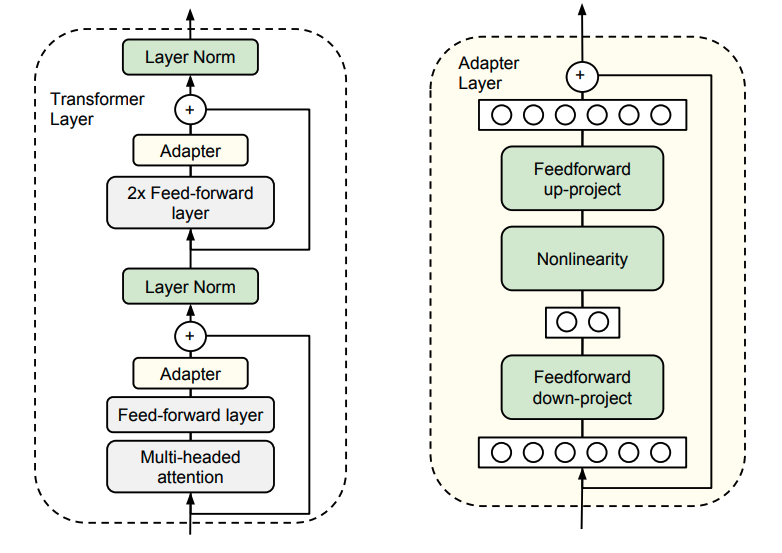

In [ ]:
# load the required libraries and set some environment variables
import os
import torch
import datasets

from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig, TaskType
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# text_column = "text"
# label_column = "text_label"
# max_length = 128
# lr = 1e-3
# num_epochs = 5
# batch_size = 8

In [ ]:
text_column = "text"
label_column = "text_label"
max_length = 128
lr = LEARNING_RATE
num_epochs = EPOCHS
batch_size = BATCH_SIZE

In [ ]:

from adapters import AutoAdapterModel
from transformers import T5Config

model_name_or_path = "t5-small"
tokenizer_name_or_path = "t5-small"

# creating model
config = T5Config.from_pretrained(
    "t5-small",
    num_labels=2,
)
model = AutoAdapterModel.from_pretrained(
    "t5-small",
    config=config,
)
# Add a new adapter
model.add_adapter("imdb", config="seq_bn")
# Alternatively, e.g.:
# model.add_adapter("rotten_tomatoes", config="lora")

# Add a seq2seq head
model.add_seq2seq_lm_head(
    "imdb",
  )

# Activate the adapter
model.train_adapter("imdb")

In [ ]:
model

In [ ]:
# # loading dataset
# dataset = load_dataset("imdb", split=['train[45%:55%]', 'test[45%:55%]', 'unsupervised[45%:55%]'])
# dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
# dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# # classes = ["negative", "positive"]
# classes = ["neg", "pos"]
# dataset = dataset.map(
#     lambda x: {"text_label": [classes[label] for label in x["label"]]},
#     batched=True,
#     num_proc=1,
# )

# dataset["train"][0]

In [ ]:
dataset = DATASET

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=2, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)


In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())

    train_accuracy = sum([1 if (true == pred).all() else 0 for true, pred in zip(true_labels, predicted_labels)]) / len(true_labels)

    model.eval()
    eval_loss = 0
    eval_preds = []
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())



    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # compute accuracy
    true_labels = [label for labels in true_labels for label in labels]
    predicted_labels = [label for labels in predicted_labels for label in labels]
    correct = sum([1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)])
    validation_accuracy = correct / len(true_labels)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=} {train_accuracy=} {validation_accuracy=}")
    logs_for_plots[epoch] = {"train_ppl": train_ppl.cpu().numpy(), "train_loss": train_epoch_loss.cpu().numpy(), "eval_ppl": eval_ppl.cpu().numpy(), "eval_loss": eval_epoch_loss.cpu().numpy(),
                             "train_accuracy": train_accuracy,
                             "validation_accuracy": validation_accuracy}





In [ ]:
# plot the logs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots], label="train", color="red")
ax[0].plot([logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots], label="val", color="blue")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot([logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots], label="train", color="red")
ax[1].plot([logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots], label="val", color="blue")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
plt.show()

## 3. LoRA (Low-Rank Adaptation)

### What exactly happens in LoRA (Low-Rank Adaptation).
LoRA approximates weight updates using low-rank matrices. It decomposes the weight update matrix into the product of two smaller matrices, significantly reducing the number of parameters to be updated.

#### A simple mathematical intuition:

Let $ W $ be the weight matrix and $ W' $ be the updated weight matrix. LoRA approximates $ W' $ as:
$$
W' \approx U V
$$
where $ U $ and $ V $ are low-rank matrices.

### Implementation
Let's start implementing the LoRA (Low-Rank Adaptation), we will proceed with the following steps:
1. **Setting Up the Environment**: Install necessary libraries and set up the GPU environment.
2. **Loading and Tokenizing the Dataset**: Prepare the data for training.
3. **Configuring LoRA**: Define the configuration for LoRA.
4. **Training the Model**: Perform the training loop with LoRA.
5. **Evaluation and Analysis**: Evaluate the fine-tuned model and analyze the results.



### LoRA: Low-Rank Adaptation of Large Language Models

LoRA: Low-Rank Adaptation of Large Language Models
https://arxiv.org/pdf/2106.09685
https://github.com/microsoft/LoRA



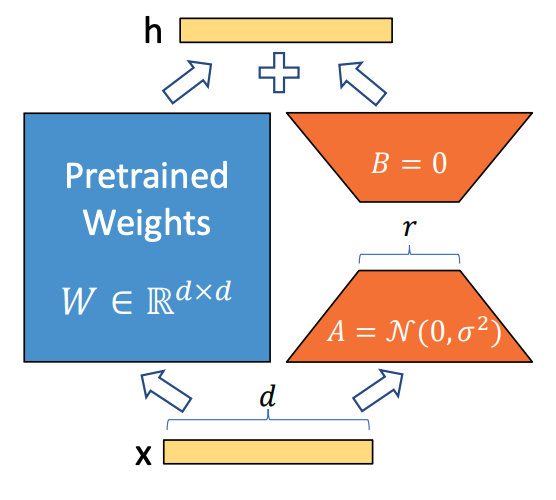

LOW-RANK ADAPTATION OF LARGE LANGUAGE MODEL RESCORING FOR
PARAMETER-EFFICIENT SPEECH RECOGNITION

https://arxiv.org/pdf/2309.15223

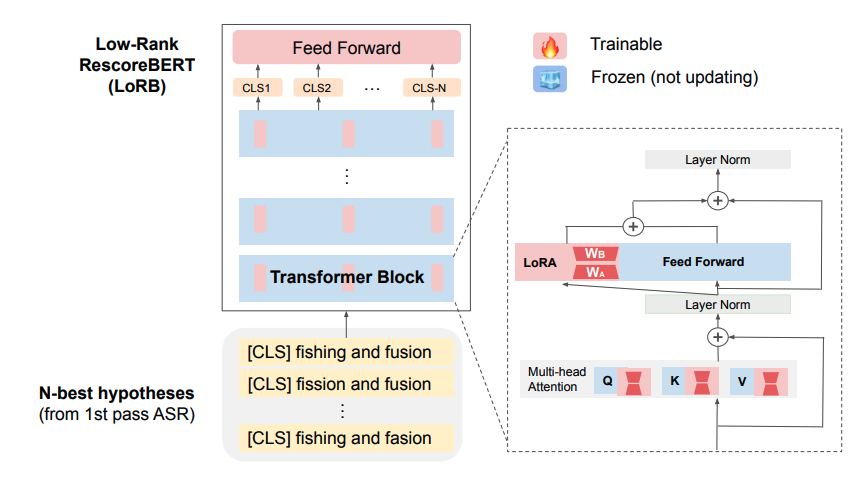

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from peft import LoraModel, LoraConfig

config = LoraConfig(
    task_type="SEQ_2_SEQ_LM",
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.01,
)
model_name_or_path = "t5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = LoraModel(model, config, "default")


In [ ]:
# # loading dataset
# dataset = load_dataset("imdb", split=['train[45%:55%]', 'test[45%:55%]', 'unsupervised[45%:55%]'])
# dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
# dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# # classes = ["negative", "positive"]
# classes = ["neg", "pos"]
# dataset = dataset.map(
#     lambda x: {"text_label": [classes[label] for label in x["label"]]},
#     batched=True,
#     num_proc=1,
# )

# dataset["train"][0]

In [ ]:
dataset = DATASET

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=2, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)


In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())

    train_accuracy = sum([1 if (true == pred).all() else 0 for true, pred in zip(true_labels, predicted_labels)]) / len(true_labels)

    model.eval()
    eval_loss = 0
    eval_preds = []
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())



    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # compute accuracy
    true_labels = [label for labels in true_labels for label in labels]
    predicted_labels = [label for labels in predicted_labels for label in labels]
    correct = sum([1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)])
    validation_accuracy = correct / len(true_labels)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=} {train_accuracy=} {validation_accuracy=}")
    logs_for_plots[epoch] = {"train_ppl": train_ppl.cpu().numpy(), "train_loss": train_epoch_loss.cpu().numpy(), "eval_ppl": eval_ppl.cpu().numpy(), "eval_loss": eval_epoch_loss.cpu().numpy(),
                             "train_accuracy": train_accuracy,
                             "validation_accuracy": validation_accuracy}





In [ ]:
# plot the logs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots], label="train", color="red")
ax[0].plot([logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots], label="val", color="blue")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot([logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots], label="train", color="red")
ax[1].plot([logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots], label="val", color="blue")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
plt.show()

AdaLoRA is a method for optimizing the number of trainable parameters to assign to weight matrices and layers, unlike LoRA, which distributes parameters evenly across all modules. More parameters are budgeted for important weight matrices and layers while less important ones receive fewer parameters.

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from peft import AdaLoraModel, AdaLoraConfig

config = AdaLoraConfig(
peft_type="ADALORA", task_type="SEQ_2_SEQ_LM", r=8, lora_alpha=32, target_modules=["q", "v"],
lora_dropout=0.01,
)

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
model = AdaLoraModel(model, config, "default")

In [ ]:
num_epochs = EPOCHS

In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())

    train_accuracy = sum([1 if (true == pred).all() else 0 for true, pred in zip(true_labels, predicted_labels)]) / len(true_labels)

    model.eval()
    eval_loss = 0
    eval_preds = []
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())



    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # compute accuracy
    true_labels = [label for labels in true_labels for label in labels]
    predicted_labels = [label for labels in predicted_labels for label in labels]
    correct = sum([1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)])
    validation_accuracy = correct / len(true_labels)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=} {train_accuracy=} {validation_accuracy=}")
    logs_for_plots[epoch] = {"train_ppl": train_ppl.cpu().numpy(), "train_loss": train_epoch_loss.cpu().numpy(), "eval_ppl": eval_ppl.cpu().numpy(), "eval_loss": eval_epoch_loss.cpu().numpy(),
                             "train_accuracy": train_accuracy,
                             "validation_accuracy": validation_accuracy}





In [ ]:
# plot the logs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots], label="train", color="red")
ax[0].plot([logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots], label="val", color="blue")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot([logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots], label="train", color="red")
ax[1].plot([logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots], label="val", color="blue")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
plt.show()

* Notice the effect of hyperparameters on different methods. Can you try improving the performance by changing the hyperparameters?


### I3A: Few-Shot Parameter-Efficient Fine-Tuning is Better and Cheaper than In-Context Learning

IA3 multiplies the model’s activations (the keys and values in the self-attention and encoder-decoder attention blocks, and the intermediate activation of the position-wise feedforward network) by three learned vectors. This PEFT method introduces an even smaller number of trainable parameters than LoRA which introduces weight matrices instead of vectors. The original model’s parameters are kept frozen and only these vectors are updated. As a result, it is faster, cheaper and more efficient to finetune for a new downstream task.

**Few-Shot Parameter-Efficient Fine-Tuning is Better and Cheaper than In-Context Learning**

https://arxiv.org/pdf/2205.05638

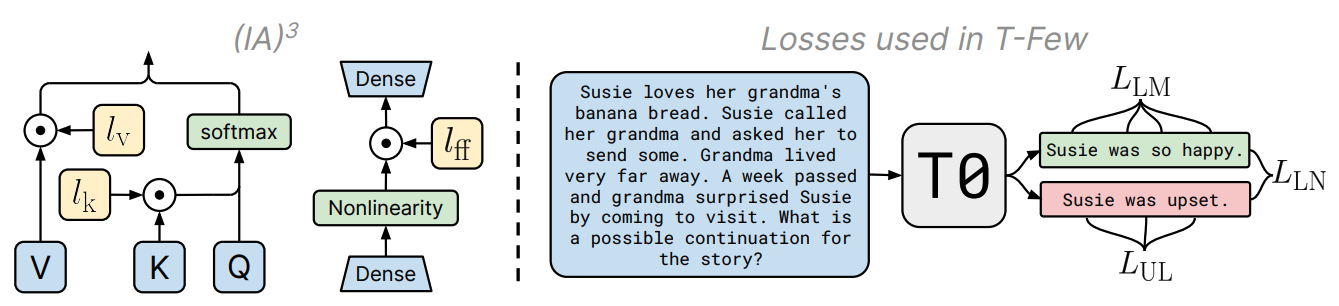

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
from peft import IA3Config, get_peft_model

peft_config = IA3Config(task_type="SEQ_2_SEQ_LM")
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


In [ ]:
# lr = 8e-3
# num_epochs = 5

In [ ]:
lr = LEARNING_RATE
num_epochs = EPOCHS

In [ ]:
dataset["train"][0]

In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

logs_for_plots = {}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())

    train_accuracy = sum([1 if (true == pred).all() else 0 for true, pred in zip(true_labels, predicted_labels)]) / len(true_labels)

    model.eval()
    eval_loss = 0
    eval_preds = []
    true_labels = []
    predicted_labels = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )
        predicted_ids = torch.argmax(outputs.logits, -1)
        true_labels.extend(batch["labels"].detach().cpu().numpy())
        predicted_labels.extend(predicted_ids.detach().cpu().numpy())



    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)

    # compute accuracy
    true_labels = [label for labels in true_labels for label in labels]
    predicted_labels = [label for labels in predicted_labels for label in labels]
    correct = sum([1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)])
    validation_accuracy = correct / len(true_labels)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=} {train_accuracy=} {validation_accuracy=}")
    logs_for_plots[epoch] = {"train_ppl": train_ppl.cpu().numpy(), "train_loss": train_epoch_loss.cpu().numpy(), "eval_ppl": eval_ppl.cpu().numpy(), "eval_loss": eval_epoch_loss.cpu().numpy(),
                             "train_accuracy": train_accuracy,
                             "validation_accuracy": validation_accuracy}





In [ ]:
# plot the logs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([logs_for_plots[epoch]["train_ppl"] for epoch in logs_for_plots], label="train", color="red")
ax[0].plot([logs_for_plots[epoch]["eval_ppl"] for epoch in logs_for_plots], label="val", color="blue")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot([logs_for_plots[epoch]["train_accuracy"] for epoch in logs_for_plots], label="train", color="red")
ax[1].plot([logs_for_plots[epoch]["validation_accuracy"] for epoch in logs_for_plots], label="val", color="blue")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
plt.show()

# Some Comments (things to notice)

* **Hyperparameters:** Notice that the hyperparameters we use in a global setting are same for all the peft approaches (there exists a commented codeblock version as well to change them). Ideally, we should have different hyperparameters for different approaches and those needs to be tuned using some experimentation (a good strategy to start with the ones provided in the paper and proceed forward).

    * **Learning Rate:** More specifically the learning rate is a very important hyperparameter to tune. It is the step size that the optimizer takes to reach the minimum. If the learning rate is too high, the optimizer might overshoot the minimum and if it is too low, the optimizer might take a long time to reach the minimum. A usual observation is more the number of trainable parameters, less will be the learning rate.

    * **Batch Size:** The batch size is the number of samples that the model sees before updating the weights. A smaller batch size will take more time to train the model but will have a better generalization. A larger batch size will train the model faster but might not generalize well.

    * **Epochs:** The number of epochs is the number of times the model sees the entire dataset. It is important to not overfit the model by training it for too many epochs.

* **Dataset Used:** In this tutorial, we consider only a small sample for shocasing the fine-tuning in a faster manner. A better strategy would be to include the entire dataset to get more reliable results.

    * **Did you notice any difference in the autoregressive dataset preprocessing?**

        * Since it was a decoder only model, the input and output format were different.
        * Moreover, another thing to notice is that we had to clip the datset samples that were going out of scope of the max length + 10 (tokens that were used for decoding)

    * It would be good to try some more popular dataset like Amazon Reviews or sentiment analysis on Twitter dataset.


* **Computation of Accuracy:** In this tutorial, we took a rough implementation of accuracy to get a weak estimation of improvements that the model is going throuh while training.

    * Does the computation of accuracy depend on the tokenizer? What should be done to compute the actual classification accuracy for the sentiment prediction in the IMDB dataset?
    
    * In practice, it would be good to write a different evaluation scheme based on the used tokenizer as well as the model type.



In general, if we want to make a one to one comparison for all the details, a more detailed experimentations would be require. We would love to see some comparison that you would come up with after going through this tutorial. Please do send us some insights if you find this tutorial helpful.


# Closing Remarks (Further Reading/Things to Explore)

Now since we have gone through the various PEFT approaches and worked around the implementation to train large models using low computation resources, we are ready to explore the usecases/applications in our our problem setup.

To gain a deeper understanding, it would be good to run some extra experiments and get familier with the workflow of PEFT approaches. A simple self-initiated project could be analyzing how the training logs changes as we use different PEFT approaches.

1. Training and Validation Loss:
    - Observe how the loss decreases over epochs for different PEFT approaches.
    - Compare the convergence speed and final loss values between DistilBERT and GPT-Neo.
    - Look for any signs of overfitting (validation loss increasing while training loss decreases).

2. LoRA Rank vs Performance:
    - Analyze how increasing the LoRA rank affects model performance.
    - Compare the optimal rank for DistilBERT and GPT-Neo.
    - Consider the trade-off between rank (parameter count) and performance.

3. PEFT Approaches Comparison:
    - Trainable Parameters:
    - Note the significant reduction in trainable parameters for all PEFT approaches compared to full fine-tuning.
    - Compare the parameter efficiency of different PEFT methods.
    - Accuracy:
        - Evaluate how close the PEFT approaches come to full fine-tuning performance.
        - Identify which PEFT method provides the best balance of parameter efficiency and performance for each model.

4. Trying with different architectures:
    - Compare the effectiveness of PEFT approaches between the two model architectures.
    - Consider how the model size and architecture influence the impact of PEFT methods.

5. Overall Insights:
    - Discuss the trade-offs between parameter efficiency, computational resources, and model performance.
    - Consider which PEFT approach might be most suitable for different scenarios (e.g., limited memory, need for high accuracy, etc.).
    - Reflect on how these insights might apply to even larger language models.




Remember, sometimes the quest to determine the most efficient strategy can itself become the most inefficient part of the process (that's what the research community is for). So, let’s keep experimenting, and embrace the journey towards optimized training. :)

![efficiency.png](https://imgs.xkcd.com/comics/efficiency.png)

Thank you for following along with this tutorial. Remember, in the world of PEFT, the only limit is your imagination—and maybe your GPU memory.

Happy fine-tuning!